## Building an ML Pipeline

In [1]:
import os
import csv
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pylab as pl
%matplotlib inline

### Task 1: Read Data

In [2]:
def read_data(f_name):
    '''
    Using os.path.splitext(file_name)[-1].lower(), find the extension of f_name and then read into pandas dataframe.
    Found here for reference: 
        http://stackoverflow.com/questions/5899497/checking-file-extension
    '''
    ext = os.path.splitext(f_name)[-1].lower()
    
    if ext == ".csv":
        df = pd.read_csv(f_name)
    
    elif ext == ".xls" or ext == ".xlsx":
        df = pd.read_excel(f_name)
        
    return df

In [3]:
credit_df = read_data("credit-data.csv")
data_dict = read_data("Data Dictionary.xls")

### Task 2 & 3: Fill Missing Values & Explore Data

In [4]:
def replace_missing_vals(df, cols_to_exclude = []):
    '''
    Function to fill NaNs with the median for the column.
    '''
    for i, col in enumerate(df.columns):
        if col in cols_to_exclude:
            pass
        else:
            df[col] = df[col].fillna(df[col].median())

    return df

processed_df = replace_missing_vals(credit_df, ['zipcode'])

In [5]:
def describe_data(df, cols_to_exclude = []):
    '''
    Takes a df and prints descriptive stats for columns unless specified to be excluded. 
    For example, the summary stats for PersonID or zipcode are not meaningful in this display.
    '''
    col_list = []
    for col in df:
        col_list.append(col)
        if str(col) in cols_to_exclude:
            pass
        else:
            print(credit_df[str(col)].describe().to_frame(), '\n')
            
    return col_list        

In [6]:
def make_box_hist_plots(df, col_name):
    '''
    Make histogram and boxplot of a given column in the data frame.
    '''
    colors = ["red", "blue", "green", "yellow", "purple", "black"]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    
    df.boxplot(column = col_name, ax = ax1, vert = False)
    ax1.set_title(col_name + " Boxplot")
    ax1.set_yticklabels([col_name], rotation = 90)
    
    df[col_name].plot(kind = "hist", alpha = 0.2, bins = 15, color = random.choice(colors), ax = ax2)
    ax2.set_title(col_name)
    
    plt.tight_layout()
    
def plot_df_summaries(df, col_dict, cols_to_exclude = []):
    
    for col in col_list:
        if str(col) in cols_to_exclude:
            pass
        else:
            make_box_hist_plots(df, col)

       SeriousDlqin2yrs
count     150000.000000
mean           0.066840
std            0.249746
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000 

       RevolvingUtilizationOfUnsecuredLines
count                         150000.000000
mean                               6.048438
std                              249.755371
min                                0.000000
25%                                0.029867
50%                                0.154181
75%                                0.559046
max                            50708.000000 

                 age
count  150000.000000
mean       52.295207
std        14.771866
min         0.000000
25%        41.000000
50%        52.000000
75%        63.000000
max       109.000000 

       NumberOfTime30-59DaysPastDueNotWorse
count                         150000.000000
mean                               0.421033
std                                4.192781
min              

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


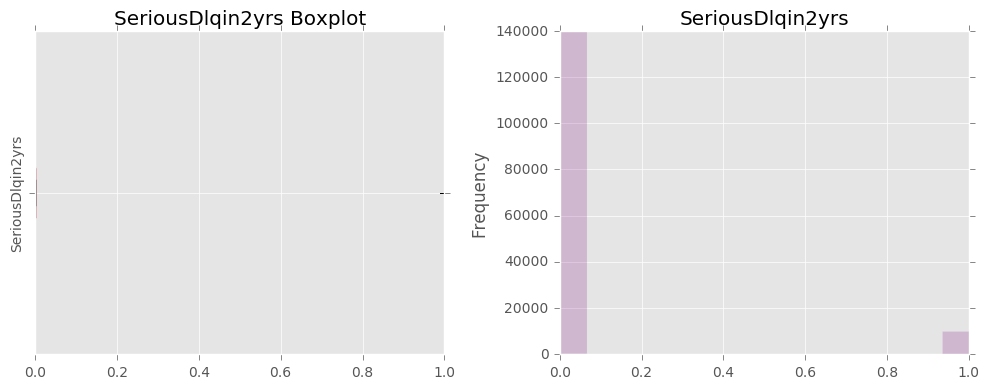

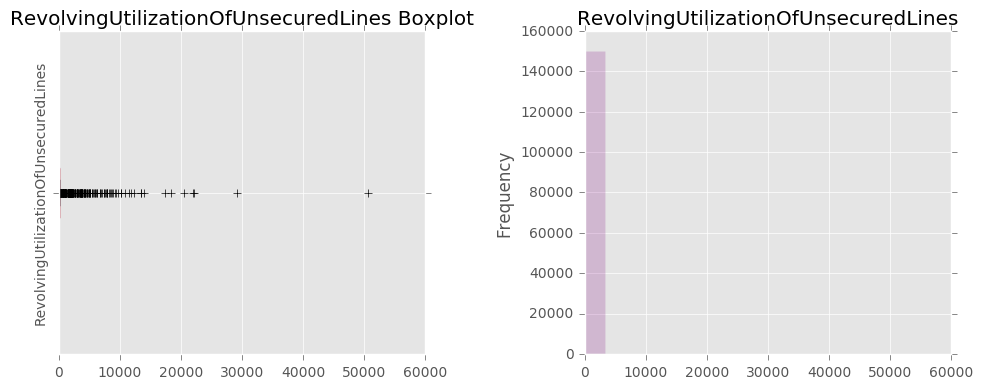

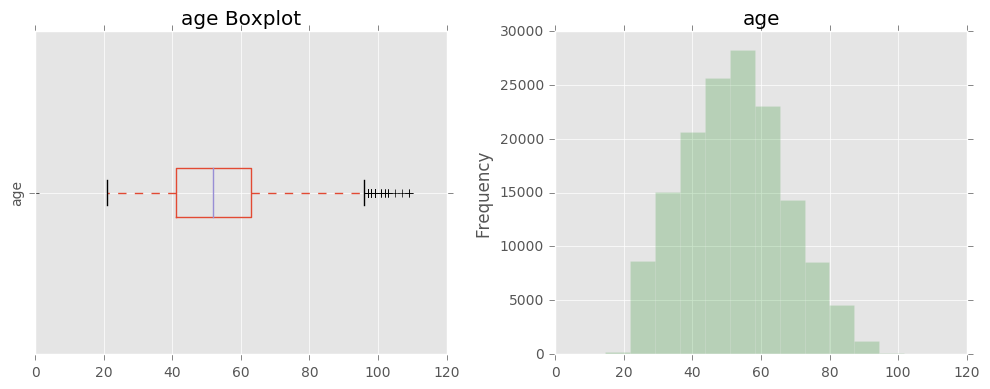

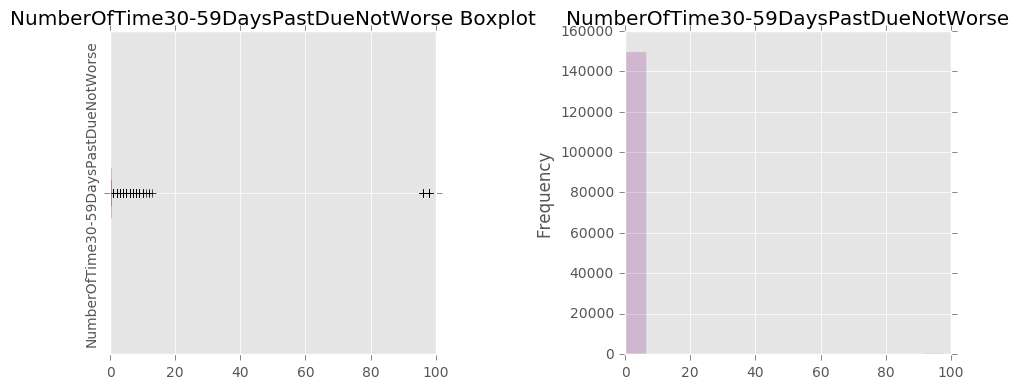

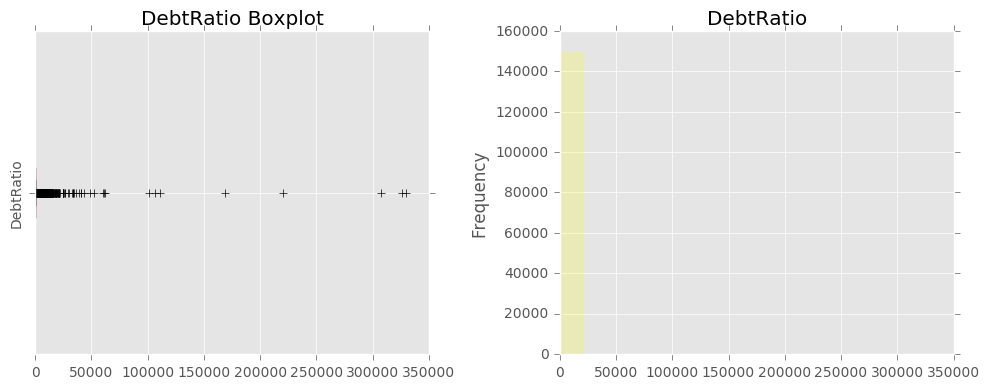

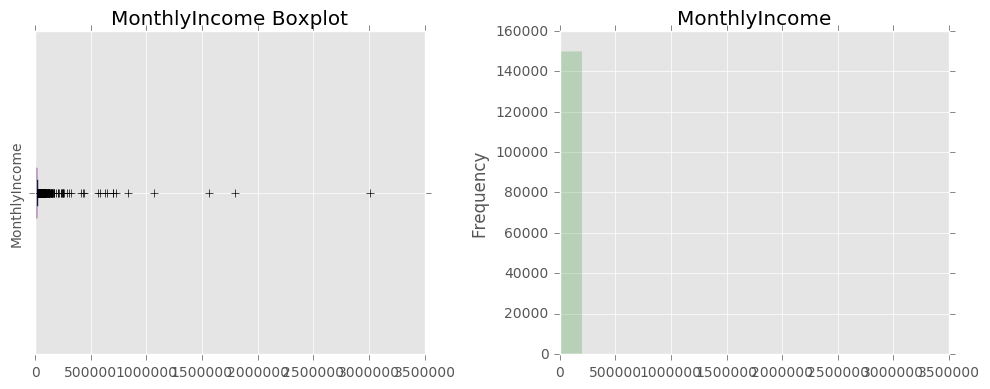

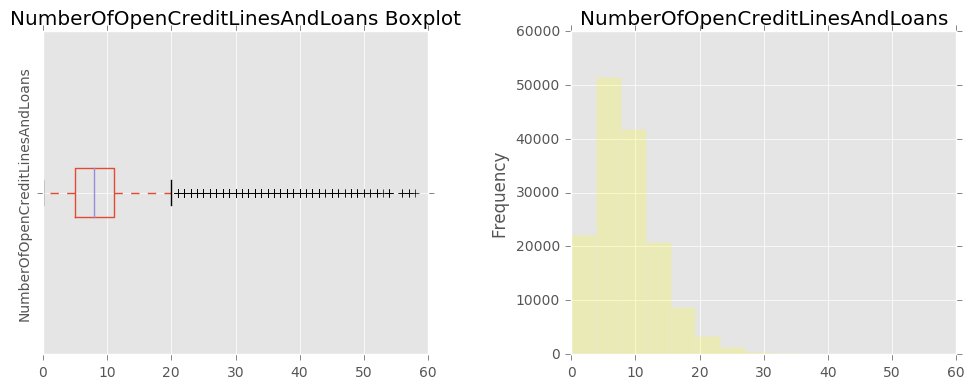

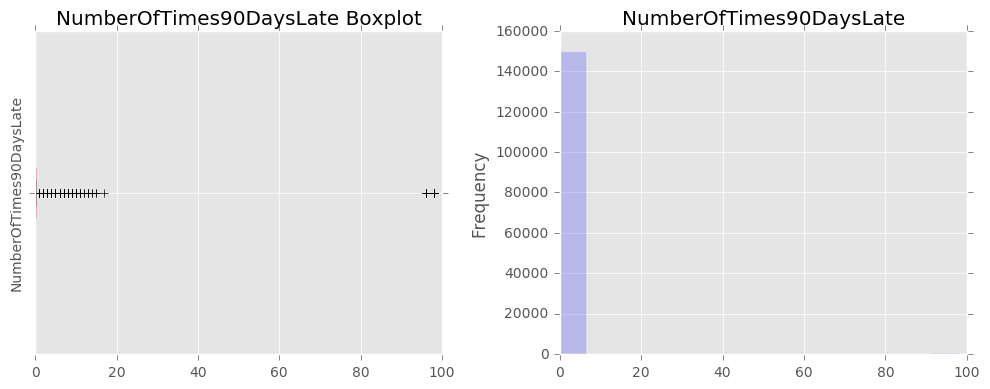

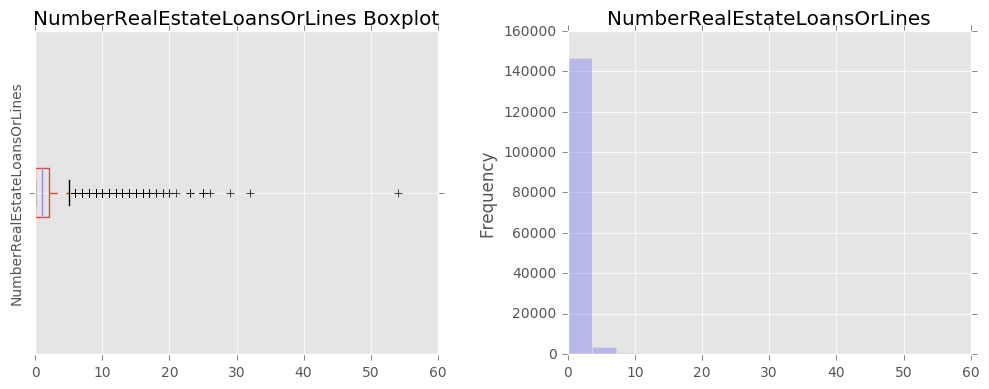

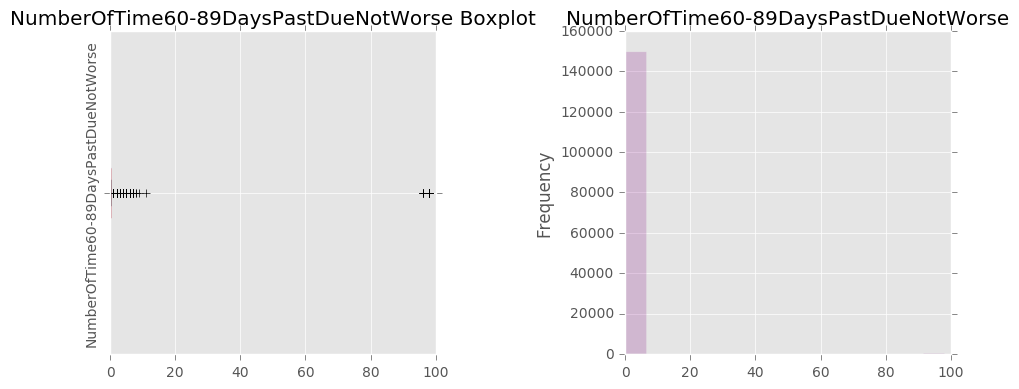

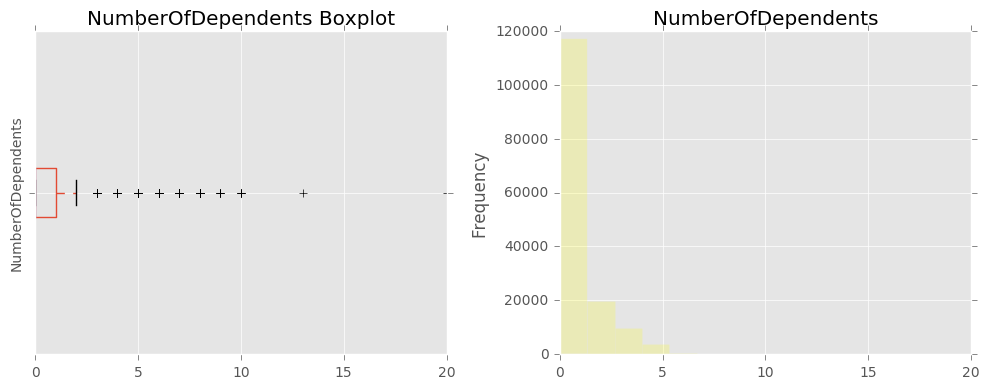

In [7]:
ignore_list = ['PersonID', 'zipcode']
col_list = describe_data(processed_df, ignore_list)
#col_dict = dict(zip([x for x in range(0, len(col_list))], [x for x in col_list]))

plot_df_summaries(credit_df, col_list, ignore_list)

### Task 4: Discretize a Continuous Variable

In [8]:
def discretize(df, col, sep_val):
    '''
    Takes a column that is a categorical variable and turns it into a binary value.
    '''
    df_copy = df.copy(deep = True)
    df_copy[col] = (df_copy[col] >= sep_val).astype(int)
    
    return df_copy

df_deps = discretize(processed_df, "NumberOfDependents", 1)
df_deps["NumberOfDependents"].describe()

count    150000.000000
mean          0.394493
std           0.488743
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: NumberOfDependents, dtype: float64

### Task 5 & 6: Build & Evaluate the Classifier

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score 

In [10]:
def imputer(df):
    '''
    Function to complete missing values by imputation 
    '''
    imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
    imputer = imputer.fit(df)
    credit_data = imputer.transform(df)
    
    return pd.DataFrame(df).reset_index(drop = True)

In [11]:
df_imputed = imputer(credit_df)

np.random.seed(seed = 1234)
test_set = np.random.uniform(0, 1 , len(df_imputed)) > .75

X_train = df_imputed[test_set == False].ix[:,1:]
X_train['age'].replace(0, X_train['age'].median(), inplace = True)
X_test = df_imputed[test_set == True].ix[:,1:]
y_train = df_imputed[test_set == False].ix[:,1]
y_test = df_imputed[test_set == True].ix[:,1]

X_train = X_train.drop(["SeriousDlqin2yrs", "zipcode"], axis = 1)
X_test = X_test.drop(["SeriousDlqin2yrs", "zipcode"], axis = 1)

In [12]:
def classifier(X_train, X_test, y_train):
    '''
    Function to select best features using RFE, then fits logistic regression model. Returns predicted values.
    '''
    reg = LogisticRegression()
    rfe = RFE(reg)
    rfe = rfe.fit(X_train, y_train)
    predicted_y = rfe.predict(X_test)

    return predicted_y

(array([ 37268.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,    182.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

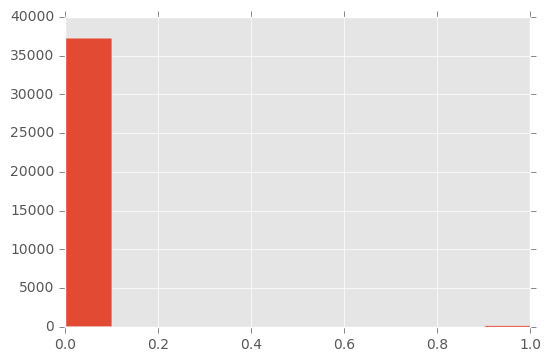

In [13]:
y_pred = classifier(X_train, X_test, y_train)
plt.hist(y_pred)

In [14]:
accuracy_score(y_test, y_pred)

0.93014686248331113